<a href="https://colab.research.google.com/github/RishithaPingili/Rishitha_INFO5502_Spring2022/blob/main/lab_assignment_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The sixth Lab-assignment (03/24/2022, 50 points in total)

The purpose of this exercise is to build a simple predicition model which can helpyou understand the workflow of machine learning. 

### Task Decription 

The goal of this assignment is to predict bike share use, given the hour, day, and information about the weather. Companies like Divvy try to predict how much demand there will be for bikes on any given day to allocate resources to redistribute bikes so that, ideally, very few bike stations are ever full (when you can’t park your bike) or empty (when you can’t pick up a bike if you want to).

The data (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06) in Github provides detailed information on the data set and necessary downloads.

### Data Description

You are provided hourly rental data spanning two years (link: https://github.com/unt-iialab/info5502-spring2022/tree/main/datasets/lab_assignment_06). For this task, the training set is comprised of the first 16 days of each month, while the test set is the 17-19th day of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. That is, predict "count" without using "count" or its components "casual" and "registered".

Data Fields

datetime - hourly date + timestamp

season - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -

1 - Clear, Few clouds, Partly cloudy, Partly cloudy

2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

### Output

Submission Format

Your output (a separate file) must have a header line and should be structured in the following format:

 datetime,count
 
 2011-01-20 00:00:00,0 
 
 2011-01-20 01:00:00,0
 
 2011-01-20 02:00:00,0
 
 ...
 
The tutorial code should demonstrate how to generate such a file from a very simple prediction model. Note, these prediction are to be done on the test file under the data tab, where you do not know the actual count, and should match the rows of the test file in count and order.

Your predictions should be compared to the ground truth information (sample_prediction.csv). Score are calculated using Root Mean Squared Error (RMSE).

### Tips

●	Add features: Pick columns/features from the data you already have. Or make a new feature from the ones you have. For example, the tutorial makes ‘hour’ from the datetime stamp, which seemed very useful. How about ‘month’?

●	Model selection: Try different models. Make sure they are regression models rather than classification models. Tip: random forest regression is a good, all around modeling strategy on complicated data sets.

●	Model tuning: Almost all regression models have parameters to tune (“hyperparameters”). E.g. polynomial regression has the degree of the polynomial (n = 1 for a line, n=2 for a quadratic fit, n=3 for a cubic fit…). Generally, one extreme makes the model too simple (e.g. a line for a curved set of points) and the other extreme makes the model overfit/be too complex, and usually the right choice is in between. For some models it is obvious what to tune (e.g. k for k nearest neighbors regression) and some don’t need much tuning with defaults that often work well. e.g. try changing the number of trees used in the random forest model!

●	Cross validation: The tutorial has a simple way of separating training and test data, however, there are better ways of splitting training and test data. Look into cross validation techniques, which are more reliable than an arbitrary split of training and test data.

●	Separate models for ...: Notice that count comes from just adding casual riders and registered riders. However, what if these two types of riders acted very differently? It might make sense to make two separate models and just add the results of both models together. This is also true for any subsets of your data that may behave wildly differently (e.g. create a separate model for each season?)

In [65]:
### You code here:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
#read train csv data
train_luc=pd.read_csv("/content/drive/MyDrive/train_luc.csv")
train_luc.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [67]:
#read test csv data using pandas
test_luc=pd.read_csv("/content/drive/MyDrive/test_luc.csv")
test_luc.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-17 00:00:00,1,1,0,2,8.20,9.850,47,15.0013
1,2011-01-17 01:00:00,1,1,0,2,8.20,9.850,44,12.9980
2,2011-01-17 02:00:00,1,1,0,2,7.38,8.335,43,16.9979
3,2011-01-17 03:00:00,1,1,0,2,7.38,9.090,43,12.9980
4,2011-01-17 04:00:00,1,1,0,2,7.38,9.850,43,8.9981


In [75]:
#extracting all the required hour , day and month columns from datetime column
train_luc['datetime']=pd.to_datetime(train_luc.datetime)
train_luc['hour'] = train_luc['datetime'].dt.hour
train_luc['day'] = train_luc['datetime'].dt.day
train_luc['month'] = train_luc['datetime'].dt.month
train_luc.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1


In [56]:
hr = np.unique(train_luc['hour'])
print("hours :",hr)

hours : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [37]:
hr_mean = {}
for h in hr:
    tmp = train_luc.loc[train_luc['hour'] == h]
    hr_mean[h] = tmp['count'].mean()

In [38]:
mnth = np.unique(train_luc['month'])
print("months :", mnth)

months : [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [39]:
mnth_mean = {}
for m in mnth:
    tmp = train_luc.loc[train_luc['month'] == m]
    mnth_mean[m] = tmp['count'].mean()

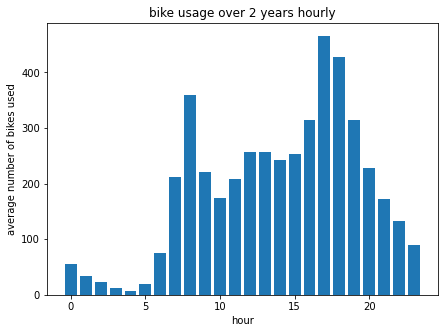

In [57]:
plot.bar(hr,[hr_mean[h] for h in hr])
plot.title("bike usage over 2 years hourly")
plot.ylabel("average number of bikes used")
plot.xlabel("hour")
plot.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


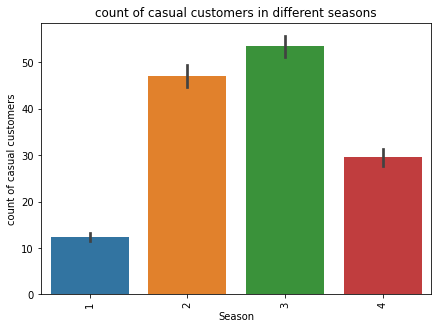

In [44]:
plot.rcParams['figure.figsize'] = [7, 5]
ax = sns.barplot('season', 'casual', data = train_luc)
plot.title("count of casual customers in different seasons")
plot.xlabel("Season")
plot.ylabel("count of casual customers")
plot.xticks(rotation=90)
plot.show()

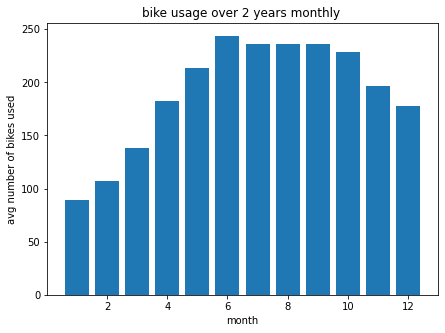

In [58]:
plot.bar(mnth, [mnth_mean[m] for m in mnth])
plot.title("bike usage over 2 years monthly ")
plot.ylabel("avg number of bikes used")
plot.xlabel("month")
plot.show()

In [72]:
#cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
kfold = KFold(n_splits=5, shuffle=True, random_state=None)
for train, test in kfold.split(train_luc):
  print('train: %s, test: %s' % (train,test))

train: [   0    1    2 ... 9168 9170 9173], test: [  11   13   14 ... 9169 9171 9172]
train: [   0    1    4 ... 9171 9172 9173], test: [   2    3    6 ... 9162 9164 9168]
train: [   0    1    2 ... 9170 9171 9172], test: [   4   16   18 ... 9159 9167 9173]
train: [   2    3    4 ... 9171 9172 9173], test: [   0    1    5 ... 9156 9166 9170]
train: [   0    1    2 ... 9171 9172 9173], test: [  10   25   32 ... 9154 9161 9163]


In [84]:
from operator import mod
columns = ['hour','month','holiday','workingday','humidity','season','weather','atemp']
mod = RandomForestRegressor(n_estimators = 100)
print("features selected for later:",columns)
print("Model used is : {0}\n".format(mod))

k=KFold(10)
cont=1;

for rslt in k.split(train_luc):
  train1= train_luc.iloc[rslt[0]]
  test1 = train_luc.iloc[rslt[1]]

  train_y=train1['count']
  train_x=train1[columns]

  test_y=test1['count']
  test_x=test1[columns]

  mod.fit(train_x, train_y)
  print("Model Score for Fold {0} is: {1}".format(cont,mod.score(train_x, train_y)))

  pred_y = mod.predict(test_x)

  # squared = False returns RMSE
  rms = mean_squared_error(test_y,pred_y,squared=False)
  print("root mean square error RMSE is : {1}\n".format(cont,rms))
  cont+=1





features selected for later: ['hour', 'month', 'holiday', 'workingday', 'humidity', 'season', 'weather', 'atemp']
Model used is : RandomForestRegressor()

Model Score for Fold 1 is: 0.978514907656604
root mean square error RMSE is : 85.81166044305462

Model Score for Fold 2 is: 0.9803624028634532
root mean square error RMSE is : 114.62337861833818

Model Score for Fold 3 is: 0.9796962475089834
root mean square error RMSE is : 100.33901602443336

Model Score for Fold 4 is: 0.9805457593557
root mean square error RMSE is : 110.03953192252477

Model Score for Fold 5 is: 0.9802372708624258
root mean square error RMSE is : 109.13612815632146

Model Score for Fold 6 is: 0.9795700465151637
root mean square error RMSE is : 93.73634400846717

Model Score for Fold 7 is: 0.979171459414194
root mean square error RMSE is : 130.60578730149308

Model Score for Fold 8 is: 0.978153858185515
root mean square error RMSE is : 107.11814021425144

Model Score for Fold 9 is: 0.9782490190356491
root mean squar

In [87]:
def month_of_year(dt):
    return datetime.strptime(dt,"%Y-%m-%d %H:%M:%S").month

def hour_of_day(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S").time().hour
print("\nsamples :",test_luc.shape[0] ,"\nfeatures :",test_luc.shape[1],"\n")

test_luc['hour'] = test_luc['datetime'].map(hour_of_day)
test_luc['month'] = test_luc['datetime'].map(month_of_year)

test_luc.head()

mod.fit(train_luc[columns], train_luc['count'])

predicted_count = mod.predict(test_luc[columns])

test_luc['count'] = predicted_count
#saved the prediction in a csv file
test_luc[['datetime','count']].to_csv('my_prediction.csv', 
    index=False, header=True)



samples : 1712 
features : 12 

